In [237]:
from dataclasses import dataclass, field
import numpy as np 
from typing import Iterable, Optional
import random
from typing import Mapping

Replicate = int
Peptide = int
Pool = int
ConstraintList = Iterable[tuple[Peptide, Peptide]]
SwapCandidateList = Iterable[tuple[Replicate, Pool, Peptide]]
ReplicateToNeighborDict = Mapping[Replicate, Mapping[Peptide, set[Peptide]]]

@dataclass
class Spec:
    num_peptides : int
    max_peptides_per_pool : int
    num_replicates : int
    invalid_neighbors : ConstraintList

@dataclass
class Solution(Spec):
    assignments : dict[int, dict[int, Iterable[int]]]
    

@dataclass
class SolutionInfo:
    replicate_to_peptide_to_current_neighbors : Mapping[Replicate, Mapping[Peptide, set[Peptide]]] = \
        field(default_factory=lambda: defaultdict(lambda: defaultdict(set)))
    replicate_to_peptide_to_cumulative_neighbors : Mapping[Replicate, Mapping[Peptide, set[Peptide]]] = \
        field(default_factory=lambda: defaultdict(lambda: defaultdict(set)))
    replicate_to_pool_to_invalid_peptides : Mapping[Replicate, Mapping[Pool, set[Peptide]]] = \
        field(default_factory=lambda: defaultdict(lambda: defaultdict(set)))
    
    

In [238]:
SolutionInfo()

SolutionInfo(replicate_to_peptide_to_current_neighbors=defaultdict(<function SolutionInfo.<lambda>.<locals>.<lambda> at 0x176c3e7a0>, {}), replicate_to_peptide_to_cumulative_neighbors=defaultdict(<function SolutionInfo.<lambda>.<locals>.<lambda> at 0x176c3d5a0>, {}), replicate_to_pool_to_invalid_peptides=defaultdict(<function SolutionInfo.<lambda>.<locals>.<lambda> at 0x176c3e0e0>, {}))

In [258]:

        
def random_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : ConstraintList = []) -> Solution:
    if num_pools is None:
        num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
    replicate_to_pool_to_peptides = {}
    for i in range(num_replicates):
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        pool_assignments = {}
        replicate_to_pool_to_peptides[i] = pool_assignments
        
        for j in range(num_pools):
            start_idx = peptides_per_pool * j
            end_idx = peptides_per_pool * (j + 1)
            pool_assignments[j] = peptide_array[start_idx:end_idx]
    return Solution(
        num_peptides=num_peptides,
        max_peptides_per_pool=peptides_per_pool,
        num_replicates=num_replicates,
        invalid_neighbors=invalid_neighbors,
        assignments=replicate_to_pool_to_peptides)


In [259]:
s = random_init()
s

Solution(num_peptides=100, max_peptides_per_pool=5, num_replicates=3, invalid_neighbors=[], assignments={0: {0: array([67, 88, 59, 34, 52]), 1: array([66, 61, 19, 54, 47]), 2: array([73, 25, 68, 86, 53]), 3: array([39,  8, 20, 45, 98]), 4: array([11, 44, 22, 60, 56]), 5: array([74, 63, 49, 16, 81]), 6: array([99, 24, 64, 15, 94]), 7: array([41, 90, 62, 84,  4]), 8: array([46, 42, 71, 26, 28]), 9: array([57, 87, 55, 31, 40]), 10: array([27, 80, 12, 95,  1]), 11: array([78, 79, 96, 91, 50]), 12: array([83, 69, 75, 30, 85]), 13: array([17, 29, 36, 76, 32]), 14: array([ 0, 65,  5,  2, 93]), 15: array([23, 43, 89, 82, 70]), 16: array([13, 72, 38, 92,  9]), 17: array([51, 18, 77, 21,  6]), 18: array([10, 35,  7, 33, 48]), 19: array([37, 58,  3, 97, 14])}, 1: {0: array([80, 81, 17, 41,  1]), 1: array([84, 29,  0, 26, 98]), 2: array([31, 59,  9,  4, 55]), 3: array([95, 89, 28, 36, 83]), 4: array([13, 50,  8, 67,  5]), 5: array([68, 97, 73, 76, 18]), 6: array([14, 63, 15, 37, 72]), 7: array([44

In [260]:
from dataclasses import dataclass
from collections import defaultdict
import copy


def analyze(s: Solution) -> SolutionInfo:
    info = SolutionInfo()
    

    if s.invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            info.replicate_to_peptide_to_cumulative_neighbors[-1][p1].add(p2)
            info.replicate_to_peptide_to_cumulative_neighbors[-1][p2].add(p1)
    
    for replicate_idx, pool_to_peptides in s.assignments.items():
        # copy over the last replicate's cumulative adjacency between peptides and update
        # it to include peptides from this replicate
        info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx] = copy.deepcopy(
            info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1])
        
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        info.replicate_to_peptide_to_current_neighbors[replicate_idx][p1].add(p2)
                        info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx][p1].add(p2)
    for replicate_idx, pool_to_peptides in s.assignments.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p in peptides:
                info.replicate_to_pool_to_invalid_peptides[replicate_idx][pool_idx].update(
                    info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1][p])
                
    return info
  

In [261]:
      

def is_valid(s : Solution) -> bool:
    info = analyze(s)
    for replicate_idx, pool_to_peptides in s.assignments.items():
        replicate_num = replicate_idx + 1
        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    print("Peptide %s twice in replicate %s" % (p, replicate_num))
                    return False
                seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1][p1]:
                            print("Peptides %s and %s already together previous pool before replicate %s" % (p1, p2, replicate_num))
                            return False
    return True 



In [255]:
is_valid(s)

True

In [262]:


def count_violations(s : Solution) -> int:
    info = analyze(s)
    
    violations = 0
    for replicate_idx, pool_to_peptides in s.assignments.items():

        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    violations +=1 
                else:
                    seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1][p1]:
                            violations +=1 
    return violations 


In [263]:
random_solutions = [random_init() for _ in range(1000)]
valids = [is_valid(s) for s in random_solutions]
print(sum(valids))

Peptides 23 and 35 already together previous pool before replicate 2
Peptides 83 and 62 already together previous pool before replicate 2
Peptides 37 and 18 already together previous pool before replicate 2
Peptides 65 and 37 already together previous pool before replicate 2
Peptides 52 and 33 already together previous pool before replicate 2
Peptides 72 and 81 already together previous pool before replicate 2
Peptides 94 and 84 already together previous pool before replicate 2
Peptides 37 and 39 already together previous pool before replicate 2
Peptides 34 and 8 already together previous pool before replicate 2
Peptides 22 and 38 already together previous pool before replicate 2
Peptides 61 and 98 already together previous pool before replicate 2
Peptides 69 and 87 already together previous pool before replicate 2
Peptides 74 and 44 already together previous pool before replicate 2
Peptides 4 and 69 already together previous pool before replicate 2
Peptides 84 and 25 already together 

Peptides 58 and 81 already together previous pool before replicate 2
Peptides 38 and 56 already together previous pool before replicate 2
Peptides 50 and 37 already together previous pool before replicate 2
Peptides 12 and 30 already together previous pool before replicate 2
Peptides 46 and 42 already together previous pool before replicate 2
Peptides 58 and 48 already together previous pool before replicate 2
Peptides 64 and 55 already together previous pool before replicate 2
Peptides 56 and 31 already together previous pool before replicate 2
Peptides 60 and 28 already together previous pool before replicate 2
Peptides 72 and 32 already together previous pool before replicate 2
Peptides 83 and 70 already together previous pool before replicate 2
Peptides 60 and 50 already together previous pool before replicate 2
Peptides 57 and 25 already together previous pool before replicate 2
Peptides 81 and 98 already together previous pool before replicate 2
Peptides 36 and 43 already togethe

Peptides 71 and 82 already together previous pool before replicate 2
Peptides 76 and 8 already together previous pool before replicate 2
Peptides 85 and 10 already together previous pool before replicate 2
Peptides 17 and 62 already together previous pool before replicate 2
Peptides 13 and 9 already together previous pool before replicate 2
Peptides 33 and 14 already together previous pool before replicate 2
Peptides 23 and 88 already together previous pool before replicate 2
Peptides 16 and 84 already together previous pool before replicate 2
Peptides 63 and 91 already together previous pool before replicate 2
Peptides 30 and 10 already together previous pool before replicate 2
Peptides 98 and 35 already together previous pool before replicate 2
Peptides 33 and 92 already together previous pool before replicate 2
Peptides 57 and 60 already together previous pool before replicate 2
Peptides 85 and 63 already together previous pool before replicate 2
Peptides 9 and 55 already together p

Peptides 35 and 2 already together previous pool before replicate 2
Peptides 7 and 83 already together previous pool before replicate 2
Peptides 5 and 69 already together previous pool before replicate 2
Peptides 25 and 50 already together previous pool before replicate 2
Peptides 21 and 88 already together previous pool before replicate 2
Peptides 54 and 35 already together previous pool before replicate 2
Peptides 34 and 86 already together previous pool before replicate 2
Peptides 98 and 71 already together previous pool before replicate 2
Peptides 7 and 87 already together previous pool before replicate 2
Peptides 5 and 59 already together previous pool before replicate 2
Peptides 73 and 3 already together previous pool before replicate 2
Peptides 49 and 68 already together previous pool before replicate 2
Peptides 80 and 19 already together previous pool before replicate 2
Peptides 0 and 78 already together previous pool before replicate 2
Peptides 5 and 40 already together previo

Peptides 0 and 17 already together previous pool before replicate 2
Peptides 14 and 49 already together previous pool before replicate 2
Peptides 26 and 85 already together previous pool before replicate 2
Peptides 96 and 83 already together previous pool before replicate 2
Peptides 69 and 73 already together previous pool before replicate 2
Peptides 25 and 44 already together previous pool before replicate 2
Peptides 23 and 74 already together previous pool before replicate 2
Peptides 12 and 67 already together previous pool before replicate 2
Peptides 67 and 15 already together previous pool before replicate 2
Peptides 71 and 22 already together previous pool before replicate 2
Peptides 20 and 36 already together previous pool before replicate 2
Peptides 88 and 66 already together previous pool before replicate 2
Peptides 34 and 47 already together previous pool before replicate 2
Peptides 79 and 7 already together previous pool before replicate 2
Peptides 27 and 51 already together 

Peptides 7 and 59 already together previous pool before replicate 2
Peptides 49 and 18 already together previous pool before replicate 2
Peptides 22 and 37 already together previous pool before replicate 2
Peptides 23 and 62 already together previous pool before replicate 2
Peptides 19 and 81 already together previous pool before replicate 2
Peptides 84 and 18 already together previous pool before replicate 2
Peptides 88 and 31 already together previous pool before replicate 2
Peptides 40 and 90 already together previous pool before replicate 2
Peptides 5 and 76 already together previous pool before replicate 2
Peptides 7 and 19 already together previous pool before replicate 2
Peptides 82 and 93 already together previous pool before replicate 2
Peptides 75 and 19 already together previous pool before replicate 2
Peptides 24 and 28 already together previous pool before replicate 2
Peptides 80 and 26 already together previous pool before replicate 2
Peptides 74 and 8 already together pr

In [265]:
print([count_violations(s) for s in random_solutions])

[56, 34, 44, 60, 44, 50, 52, 42, 58, 42, 54, 40, 32, 42, 46, 48, 52, 46, 44, 42, 50, 54, 66, 54, 50, 38, 60, 56, 50, 50, 40, 36, 50, 52, 42, 44, 60, 42, 46, 48, 46, 46, 36, 54, 52, 46, 60, 34, 66, 52, 34, 34, 58, 38, 56, 42, 50, 50, 38, 66, 52, 48, 46, 52, 48, 48, 38, 52, 50, 50, 46, 34, 44, 44, 40, 62, 46, 44, 50, 66, 44, 42, 56, 42, 44, 56, 52, 60, 48, 58, 64, 38, 54, 58, 52, 48, 40, 36, 44, 52, 48, 42, 44, 50, 54, 60, 52, 56, 38, 44, 52, 40, 46, 50, 32, 42, 46, 58, 50, 38, 40, 40, 46, 28, 66, 60, 44, 42, 48, 62, 44, 46, 42, 44, 62, 54, 46, 60, 36, 56, 48, 36, 64, 82, 50, 38, 42, 52, 60, 56, 52, 52, 58, 56, 58, 42, 52, 42, 52, 46, 58, 52, 34, 56, 44, 40, 50, 56, 46, 48, 50, 64, 44, 54, 58, 48, 46, 48, 58, 50, 36, 38, 48, 52, 54, 38, 38, 50, 62, 58, 52, 50, 46, 46, 42, 52, 42, 62, 38, 50, 54, 54, 42, 34, 28, 52, 50, 64, 42, 40, 66, 62, 54, 48, 46, 38, 46, 40, 54, 50, 44, 52, 50, 48, 58, 46, 46, 48, 50, 48, 54, 44, 34, 60, 30, 56, 42, 64, 50, 46, 46, 56, 44, 36, 64, 48, 28, 58, 32, 58,

In [268]:


def find_violating_peptides(s: Solution) -> tuple[SwapCandidateList, SolutionInfo] :
    info = analyze(s)
    needs_swap = []
    for replicate_idx, pool_to_peptides in s.assignments.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1][p1]:
                            needs_swap.append((replicate_idx, pool_idx, p2))
        
    return needs_swap, info

def improve_solution(
        s : Solution, 
        verbose : bool = False):
    
    needs_swap, info = find_violating_peptides(s)
    
    random.shuffle(needs_swap)
    
    swapped_pools = set()
    swapped_peptides = set()
    for (replicate_idx, pool_idx_a, peptide_a) in needs_swap:
        if pool_idx_a in swapped_pools or peptide_a in swapped_peptides:
            continue
 
        pool_to_peptides = s.assignments[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]

        # if a pool is empty, just move the offending peptide there
        empty_pools = {pool_idx for (pool_idx, pool_peptides) in pool_to_peptides.items() if len(pool_peptides) == 0}
        if empty_pools:
            pool_idx_b = random.choice(list(empty_pools))
            pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a])
            pool_to_peptides[pool_idx_b] = np.array([peptide_a])
            swapped_pools.add(pool_idx_a)
            swapped_pools.add(pool_idx_b)
            swapped_peptides.add(peptide_a)
        else:
            other_peptides = []
            peptide_to_pool_idx = {}
            for pool_idx_i, pool_peptides_i in pool_to_peptides.items():
                if pool_idx_i != pool_idx_a and pool_idx_i not in swapped_pools:
                    all_peptides_ok = True
                    for p in pool_peptides_i:
                        peptide_to_pool_idx[p] = pool_idx_i
                        all_peptides_ok = all_peptides_ok and (
                            peptide_a not in info.replicate_to_peptide_to_cumulative_neighbors[replicate_idx - 1][p])
                    if all_peptides_ok:
                        other_peptides.extend([p for p in pool_peptides_i if p not in swapped_peptides])

            if len(other_peptides) == 0:
                if verbose:
                    print("Not able to find a valid peptide to swap with for (%s, %s, %s)" % (replicate_idx, pool_idx_a, peptide_a))
                continue
            peptide_b = random.choice(other_peptides)
            pool_idx_b = peptide_to_pool_idx[peptide_b]
            assert peptide_a != peptide_b
            assert pool_idx_a != pool_idx_b
            pool_b = pool_to_peptides[pool_idx_b]
            if len(pool_a) > 1 and len(pool_b) < s.max_peptides_per_pool and random.choice([False, True]):
                # just move peptide a to the pool with fewer than max peptides
                if verbose:
                    print("Moving peptide %d from pool %d to pool %d" % (peptide_a, pool_idx_a, pool_idx_b))
                pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a])
                pool_to_peptides[pool_idx_b] = np.array(list(pool_b) + [peptide_a])
                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
            else:

                if verbose:
                    print("Before swap")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                # actually swap them
                pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a] + [peptide_b])
                pool_to_peptides[pool_idx_b] = np.array([i for i in pool_b if i != peptide_b] + [peptide_a])

                if verbose:
                    print("After")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
                swapped_peptides.add(peptide_b)
        
    return replicate_to_pool_to_peptides

def improve_until_covergence(
        s : Solution,
        max_iters : int = 100, 
        verbose : bool = False,
        add_pool_if_stuck : bool = True,
        return_history : bool = False) -> bool:
    """
    Iteratively update solution by randomly swapping a violating peptide with a random other peptide
    
    Args
    ----
    solution
        Initial solution which will be modified in-place
    
    max_iters
        Maximum number of swaps to consider performing
        
    verbose
        Print number of violations for each iteration
    
    add_pool_if_stuck
        If no improvements have been made for 10 iters, add a pool 
        to the last replicate
    
    return_history 
        Return array of constraint validation counts per iteration
        
        
    Returns True if non-violating solution found, False if solution still has violations after
    max_iters
    """
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors = s.invalid_neighbors
    
    old_num_violations = count_violations(s)
    history = [old_num_violations]
    if verbose:
        print("Initial solution has %s violations" % (old_num_violations,))
    num_iters_without_improvement = 0
    for i in range(max_iters):
        history.append(old_num_violations)
        improve_solution(s)
        new_num_violations = count_violations(s)
            
        history.append(new_num_violations)
        if verbose:
            print("%d) %d -> %d" % (i + 1, old_num_violations, new_num_violations))
        
        if old_num_violations <= new_num_violations:
            num_iters_without_improvement += 1
        else:
            num_iters_without_improvement = 0
        
        
        old_num_violations = new_num_violations
        
        if new_num_violations == 0:
            if verbose:
                print("Found valid solution after %d swaps" % (i + 1,))
            break
        
        if num_iters_without_improvement > 10 and add_pool_if_stuck:
            last_replicate_idx = s.num_replicates - 1
            last_replicate = s.assignments[last_replicate_idx]
            num_pools = len(last_replicate)
            last_replicate[num_pools] = np.array([])
            if verbose:
                print("Adding pool %d to replicate %d" % (num_pools, last_replicate_idx + 1))
    
    result = (old_num_violations == 0)
    if return_history:
        return result, np.array(history)
    else:
        return result 

In [269]:
s = random_init(1000, 32)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2946 violations


NameError: name 'replicate_to_pool_to_peptides' is not defined

In [226]:
s.assignments[2]

{0: array([747, 920, 453, 555, 282, 808, 837, 974, 264, 727, 549,  93, 897,
         26,  98, 158, 639, 193, 323, 457, 218, 495, 188, 443, 580, 468,
         84, 911, 250, 435, 664]),
 1: array([505, 527, 801,  13, 627, 155, 439, 164, 906, 598, 693, 467, 547,
        581,  61, 810,  73, 793, 232, 807, 770, 415, 249, 436, 558, 945,
        691, 966, 970]),
 2: array([706, 489, 946, 466, 154, 180, 421, 476, 526, 432, 337, 256, 913,
        669,   5, 557, 151, 572, 338, 381, 122, 342, 728, 979, 239, 473,
        643, 789, 546]),
 3: array([461, 514, 854, 933, 119, 736, 281, 875,  51, 113, 873, 425, 160,
        525, 217, 980, 718, 579, 988, 785, 429,  40,  14, 242, 528, 524,
        509, 504,  89,  31, 870]),
 4: array([107, 133, 462, 740, 896, 750,  76,  30,  82, 550, 303, 994, 884,
        434, 120, 934, 844, 864, 888, 746, 954, 419, 743, 714, 930, 448,
        240,  60, 655, 412]),
 5: array([515, 767, 179, 545, 828, 183, 189, 687, 586, 787, 464, 967, 123,
        519, 267, 480, 621, 8

{0: {0: array([455, 697,  33, 443, 253, 474, 535, 753, 309, 167, 907, 254, 794,
         416, 514, 487, 135, 569, 228, 884, 369, 675, 817, 586, 331,  68,
         459, 121, 727, 739, 826, 980]),
  1: array([860, 107, 706,  98, 413, 102, 767, 848, 239, 558, 394, 132, 444,
         358, 305, 295, 405, 335, 566, 464, 275, 391, 324, 993, 423, 553,
         782, 338, 718, 705, 176, 824]),
  2: array([679, 533, 709, 188, 722, 389, 285, 182, 579, 873, 850, 853, 559,
         898, 475, 777, 941, 235, 496,  63, 207, 885, 951, 862, 249, 627,
         582, 427, 596, 458, 990, 802]),
  3: array([978,  47, 316, 540, 456, 519, 932, 959, 348, 602,  74, 788,  23,
         465, 482,  30, 178, 268, 643, 527,  39, 660, 584, 211, 538, 755,
         517, 736,  89, 693, 479, 214]),
  4: array([278, 560,   2, 922, 453,  20, 845, 221, 546, 481,  58, 398, 787,
         712, 631, 485, 134, 664, 116, 683, 117, 668, 532,   7, 785, 195,
         258, 301, 956, 614, 462, 103]),
  5: array([813, 437, 933, 149, 265, 

In [105]:
import matplotlib

In [107]:
import matplotlib.pyplot as plt

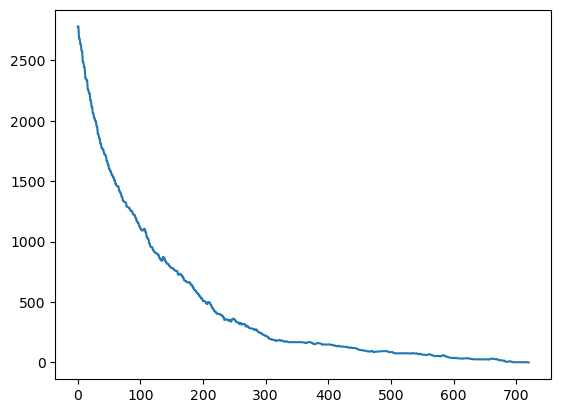

In [227]:
plt.plot(history)

In [183]:
s = random_init(1000, 32)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2940 violations
1) 2940 -> 2866
2) 2866 -> 2768
3) 2768 -> 2734
4) 2734 -> 2652
5) 2652 -> 2556
6) 2556 -> 2492
7) 2492 -> 2460
8) 2460 -> 2378
9) 2378 -> 2338
10) 2338 -> 2280
11) 2280 -> 2252
12) 2252 -> 2188
13) 2188 -> 2100
14) 2100 -> 2038
15) 2038 -> 2018
16) 2018 -> 1974
17) 1974 -> 1918
18) 1918 -> 1876
19) 1876 -> 1830
20) 1830 -> 1792
21) 1792 -> 1766
22) 1766 -> 1742
23) 1742 -> 1722
24) 1722 -> 1704
25) 1704 -> 1644
26) 1644 -> 1632
27) 1632 -> 1602
28) 1602 -> 1568
29) 1568 -> 1540
30) 1540 -> 1526
31) 1526 -> 1474
32) 1474 -> 1444
33) 1444 -> 1410
34) 1410 -> 1390
35) 1390 -> 1382
36) 1382 -> 1398
37) 1398 -> 1374
38) 1374 -> 1354
39) 1354 -> 1330
40) 1330 -> 1306
41) 1306 -> 1298
42) 1298 -> 1266
43) 1266 -> 1270
44) 1270 -> 1236
45) 1236 -> 1228
46) 1228 -> 1200
47) 1200 -> 1180
48) 1180 -> 1178
49) 1178 -> 1146
50) 1146 -> 1128
51) 1128 -> 1118
52) 1118 -> 1102
53) 1102 -> 1110
54) 1110 -> 1108
55) 1108 -> 1074
56) 1074 -> 1064
57) 1064 -> 1044
58)

KeyboardInterrupt: 

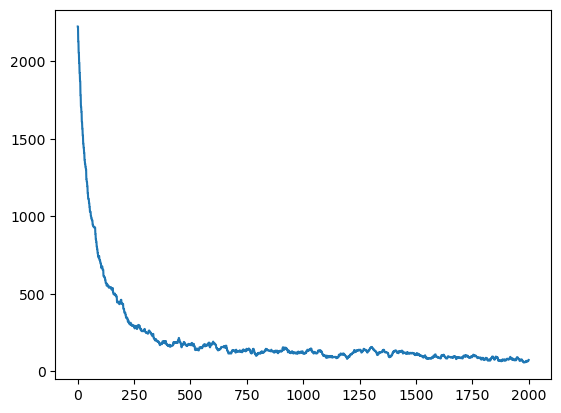

In [112]:
plt.plot(history)

In [114]:
s = random_init(1000, 24)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 1476 violations
1) 1476 -> 1424
2) 1424 -> 1362
3) 1362 -> 1302
4) 1302 -> 1228
5) 1228 -> 1168
6) 1168 -> 1116
7) 1116 -> 1046
8) 1046 -> 1004
9) 1004 -> 974
10) 974 -> 966
11) 966 -> 924
12) 924 -> 880
13) 880 -> 844
14) 844 -> 832
15) 832 -> 802
16) 802 -> 752
17) 752 -> 730
18) 730 -> 696
19) 696 -> 688
20) 688 -> 674
21) 674 -> 650
22) 650 -> 646
23) 646 -> 626
24) 626 -> 614
25) 614 -> 594
26) 594 -> 606
27) 606 -> 584
28) 584 -> 558
29) 558 -> 532
30) 532 -> 518
31) 518 -> 492
32) 492 -> 466
33) 466 -> 448
34) 448 -> 440
35) 440 -> 428
36) 428 -> 412
37) 412 -> 410
38) 410 -> 388
39) 388 -> 368
40) 368 -> 336
41) 336 -> 322
42) 322 -> 300
43) 300 -> 304
44) 304 -> 306
45) 306 -> 314
46) 314 -> 284
47) 284 -> 260
48) 260 -> 244
49) 244 -> 244
50) 244 -> 242
51) 242 -> 234
52) 234 -> 222
53) 222 -> 224
54) 224 -> 222
55) 222 -> 210
56) 210 -> 192
57) 192 -> 186
58) 186 -> 182
59) 182 -> 172
60) 172 -> 166
61) 166 -> 154
62) 154 -> 148
63) 148 -> 138
64) 138 ->

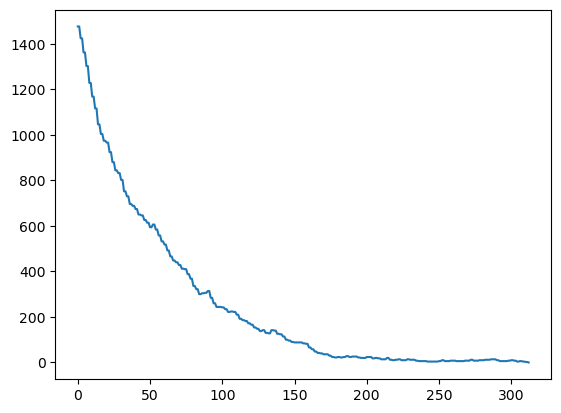

In [115]:
plt.plot(history)

In [116]:
s

{0: {0: array([747, 128, 693, 676, 797, 376, 223, 424,  21, 181, 174, 938, 666,
         177, 205, 451, 257, 885, 475, 767, 936, 409, 875, 598]),
  1: array([932, 874, 979, 562, 307, 970, 333,  19, 301, 436, 106, 335, 102,
         674, 446, 356, 295, 945, 766, 607, 139, 859,  50, 486]),
  2: array([438, 160, 600,  55,   2, 841, 881, 831, 799, 122, 590, 312, 266,
         821, 209, 974, 933, 478, 929, 552, 720, 347, 372, 368]),
  3: array([650, 242, 761, 653,  14, 479, 510, 101, 405, 985, 439, 734, 311,
          79, 951, 865, 796, 245, 893, 587, 645, 567, 563, 805]),
  4: array([890, 887, 686, 732, 329, 564, 741,  18, 456, 199, 735, 217, 958,
         271, 442,  88, 412, 809, 506, 386, 449, 901, 144,  15]),
  5: array([490, 884, 944,  31, 359, 776, 119, 176, 662, 864, 906, 615, 553,
         304, 400, 632, 129, 429, 942, 670, 649,  39, 561,  12]),
  6: array([555, 364,   9,   8, 267, 343, 581,  28, 379, 705, 243, 905, 773,
         852, 774, 448, 820, 458, 533, 955, 415, 560, 822, 403